<a href="https://colab.research.google.com/github/hcarlens/DQN/blob/master/Simple_DQN_on_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
import numpy as np
import gym
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [29]:
# set hyperparameters (mostly taken from DQN paper)
num_episodes = 1000
max_num_steps = 200
start_epsilon = 1
end_epsilon = 0.01
epsilon_decay_rate = 0.99
discount_rate = 0.99
batch_size = 32
optimizer_learning_rate = 0.0025
buffer_length = 50000
target_update_steps = 1000

In [17]:
# define Q-network (two layers with 32 neurons each)
# 4 inputs (one for each scalar observable) +1 to represent the action
# todo: try other network architectures
# todo: change to 4 inputs; 5 outputs to require fewer forward passes
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(5,)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(learning_rate=optimizer_learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [21]:
# define a memory buffer
class MemoryBuffer:
  def __init__(self):
    self.experience_buffer = deque(maxlen=buffer_length)

  def add_memory(self, memory):
    self.experience_buffer.append(memory)
    
  def sample_minibatch(self, batch_size):
    # sample from experience buffer
    minibatch = random.sample(self.experience_buffer, min(len(self.experience_buffer), batch_size))
    input_cache = []
    label_cache = []
    
    # todo: make this more efficient by turning the sampled mini batch into one tensor
    # todo: move state processing code out of memory class
    # parse all the relevant states in our replay buffer
    for state, action, reward, next_state, done in minibatch:
        if done: 
            target_q_value = reward
        else:         
            max_q_next_state = max(target_network.predict(np.array([np.append(next_state,0), np.append(next_state,1)])))[0]
            
            target_q_value = reward + discount_rate * max_q_next_state

        input_cache.append(np.append(state, action))
        label_cache.append(np.array(target_q_value))
    return input_cache, label_cache

In [ ]:
# initialise environment, required objects, and some variables
env = gym.make('CartPole-v0')

q_network = build_model()
target_network = build_model()
memory_buffer = MemoryBuffer()

epsilon = start_epsilon
episode_lengths = []
total_steps = 0

# run through episodes
for e in range(num_episodes):
    observation = env.reset()
    
    for t in range(max_num_steps):
        input = np.array([np.append(observation,0), np.append(observation,1)])
        # todo: review distribution of inputs, and consider normalising
        
        # set the target network to be the q-network every so often
        if total_steps % target_update_steps == 0:
            target_network.set_weights(q_network.get_weights())
            print(total_steps, ' steps taken. Target network weights updated. ')

        # with probability epsilon, choose a random action
        # otherwise use Q-network to pick action 
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_network.predict(input))

        next_observation, reward, done, info = env.step(action)
        
        # add memory to buffer
        memory = (observation, action, reward, next_observation, done)
        memory_buffer.add_memory(memory)
        
        # sample a minibatch of experiences and update q-network
        minibatch_inputs, minibatch_q_values = memory_buffer.sample_minibatch(batch_size)
        q_network.fit(np.array(minibatch_inputs), np.array(minibatch_q_values), verbose=0)
        
        observation = next_observation
        total_steps += 1
        if done or t == max_num_steps - 1:
            break 
            
    episode_lengths.append(t)
    if e % 10 == 0:
        print("Episode {} finished after {} timesteps. 100 ep running avg {}. Epsilon {}. Memory buffer length {}.".format(e, t+1, np.floor(np.average(episode_lengths[-100:])), epsilon, len(memory_buffer.experience_buffer)))

    # decrease epsilon value
    epsilon = max(epsilon * epsilon_decay_rate, end_epsilon)


0  steps taken. Target network weights updated. 
Episode 0 finished after 38 timesteps. 100 ep running avg 37.0. Epsilon 1. Memory buffer length 38.
Episode 10 finished after 25 timesteps. 100 ep running avg 22.0. Epsilon 0.9043820750088043. Memory buffer length 260.
Episode 20 finished after 10 timesteps. 100 ep running avg 19.0. Epsilon 0.8179069375972307. Memory buffer length 434.
Episode 30 finished after 12 timesteps. 100 ep running avg 19.0. Epsilon 0.7397003733882802. Memory buffer length 629.
Episode 40 finished after 18 timesteps. 100 ep running avg 18.0. Epsilon 0.6689717585696803. Memory buffer length 792.
Episode 50 finished after 16 timesteps. 100 ep running avg 17.0. Epsilon 0.6050060671375365. Memory buffer length 923.
1000  steps taken. Target network weights updated. 
Episode 60 finished after 9 timesteps. 100 ep running avg 16.0. Epsilon 0.5471566423907612. Memory buffer length 1044.
Episode 70 finished after 13 timesteps. 100 ep running avg 15.0. Epsilon 0.4948386596

42000  steps taken. Target network weights updated. 
Episode 500 finished after 172 timesteps. 100 ep running avg 165.0. Epsilon 0.01. Memory buffer length 42566.
43000  steps taken. Target network weights updated. 
Episode 510 finished after 130 timesteps. 100 ep running avg 159.0. Epsilon 0.01. Memory buffer length 43743.
44000  steps taken. Target network weights updated. 
45000  steps taken. Target network weights updated. 
Episode 520 finished after 128 timesteps. 100 ep running avg 155.0. Epsilon 0.01. Memory buffer length 45171.
46000  steps taken. Target network weights updated. 
Episode 530 finished after 200 timesteps. 100 ep running avg 153.0. Epsilon 0.01. Memory buffer length 46644.
47000  steps taken. Target network weights updated. 
48000  steps taken. Target network weights updated. 
Episode 540 finished after 113 timesteps. 100 ep running avg 147.0. Epsilon 0.01. Memory buffer length 48038.
49000  steps taken. Target network weights updated. 
Episode 550 finished after

105000  steps taken. Target network weights updated. 
106000  steps taken. Target network weights updated. 
Episode 950 finished after 130 timesteps. 100 ep running avg 179.0. Epsilon 0.01. Memory buffer length 50000.
107000  steps taken. Target network weights updated. 
Episode 960 finished after 125 timesteps. 100 ep running avg 172.0. Epsilon 0.01. Memory buffer length 50000.
108000  steps taken. Target network weights updated. 
Episode 970 finished after 131 timesteps. 100 ep running avg 165.0. Epsilon 0.01. Memory buffer length 50000.
109000  steps taken. Target network weights updated. 
110000  steps taken. Target network weights updated. 
Episode 980 finished after 112 timesteps. 100 ep running avg 160.0. Epsilon 0.01. Memory buffer length 50000.
111000  steps taken. Target network weights updated. 
112000  steps taken. Target network weights updated. 
Episode 990 finished after 200 timesteps. 100 ep running avg 161.0. Epsilon 0.01. Memory buffer length 50000.
113000  steps take

Text(0.5, 1.0, 'No separate target net; 0.0025 lr')

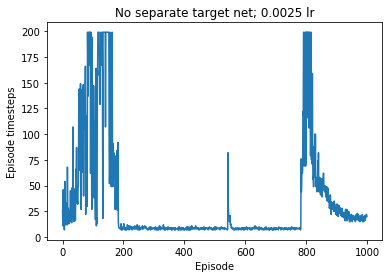

In [20]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(episode_lengths,label='episode length')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode timesteps')
ax.set_title('No separate target net; 0.0025 lr')

Text(0.5, 1.0, 'Target net update frequency 10k; 0.0025 lr')

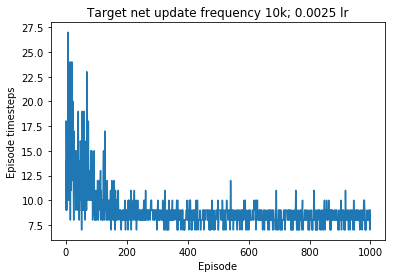

In [28]:
%matplotlib inline
fig1, ax1 = plt.subplots()
plt.plot(episode_lengths,label='episode length')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode timesteps')
ax1.set_title('Target net update frequency 10k; 0.0025 lr')